## 1) Preprocess all the necessary variables
### 1.1) Build feature, target and initial normalization files

In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

Using TensorFlow backend.
/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 1/22/2019 - I get very confused by all the types of precip so there are some tests below.  
https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/tphysbc_internallythreaded.F90  
look for wtricesink and icesink
  
The different types of precipitation are:  
PRECC,PRECL,PRECSC,PRECSL,PRECSTEN,PRECT,PRECTEND.  
PRECC: Convective precipitation rate (m/s)  
PRECL: Large-scale precipitation rate (m/s)  
PRECSC: Convective snow rate - water equivalent (m/s)  
PRECSL: Large-scale snow rate - water equivalent (m/s)  
PRECSTEN: Large-scale snow rate - water equivalent (m/s)  
PRECT: Total precipitation rate (m/s)  
PRECTEND: Large-scale snow rate - water equivalent (m/s)  
  
So there seems to be problematic flags regarding the snow rate.  
  
The relation for the liquid precipitation rate is:  
PRECT = PRECC + PRECL  
Total precip = Convective precip + Large-scale precip  

There doesn't seem to be an obvious relation for the snow rate.  
  
According to the mass/water conservation, the condensation sink at the surface is:
PRECT [liquid] + 1e-3 * PRECTEND [??snow converted to liquid equivalent??]  
and that is balanced by the latent heat flux, proportional to the evaporation source.  
  
But apparently there's another component of the snow rate that is important for energy conservation but doesn't enter the water conservation equation. If I naively follow:  
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/dev/old_notebooks/energy_conservation.ipynb  
that precipitation term is a source rather than a sink for the energy:  
+L_F*( PRECSC + PRECSL + 1e-3 * PRECSTEN )  
Maybe it describes the liq->snow conversion in the column? Unsure...
By analogy to the ??liquid precip??, we define:  
PRECST = PRECSC + PRECSL  
and also predict PRECSTEN. 

tgb - 1/22/2019 - Let's predict these two more quantities and see if we can conserve FMSE :)



In [3]:
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
import xarray as xr
import numpy as np
ds = xr.open_dataset(DATADIR + 'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc', 
                     decode_times=False)
# The large-scale snow rate equivalent needs to be multiplied by 1e-3 for water conservation
#print(ds.PRECC)
#print(ds.PRECL)
print(ds.DTVKE.attrs,ds.DTVKE.mean(dim=['lon','lat','time'])/1800,'sum=',np.sum(ds.DTVKE.mean(dim=['lon','lat','time'])/1800))
print(ds.TPHYSTND.attrs,ds.TPHYSTND.mean(dim=['lon','lat','time']),'sum=',np.sum(ds.TPHYSTND.mean(dim=['lon','lat','time'])))
print(ds.PRECSC.mean(dim=['lon','lat','time']))
print(ds.PRECSL.mean(dim=['lon','lat','time']))
print(ds.PRECSC.mean(dim=['lon','lat','time'])+ds.PRECSL.mean(dim=['lon','lat','time']))
print(ds.PRECSTEN.mean(dim=['lon','lat','time']))
print(ds.PRECTEND.attrs,ds.PRECTEND.mean(dim=['lon','lat','time']))

OrderedDict([('units', 'K/s'), ('long_name', 'dT/dt vertical diffusion KE dissipation'), ('cell_method', 'time: mean')]) <xarray.DataArray 'DTVKE' (lev: 30)>
array([6.190228e-11, 7.607866e-11, 6.988708e-11, 7.102008e-11, 8.425537e-11,
       1.770534e-10, 6.262000e-10, 5.441891e-09, 1.147568e-08, 1.310354e-08,
       1.299817e-08, 9.034349e-09, 4.209920e-09, 3.817676e-09, 3.808339e-09,
       2.463906e-09, 1.168622e-09, 4.617561e-10, 2.209182e-10, 1.410370e-10,
       1.227459e-10, 2.885002e-10, 2.581773e-09, 1.329442e-08, 3.226186e-08,
       6.681960e-08, 1.263978e-07, 2.324936e-07, 4.423991e-07, 1.105985e-05],
      dtype=float32)
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6 sum= <xarray.DataArray 'DTVKE' ()>
array(1.204602e-05, dtype=float32)
OrderedDict([('units', 'K/s'), ('long_name', 'T physics tendency'), ('cell_method', 'time: mean')]) <xarray.DataArray 'TPHYSTND' (lev: 30)>
array([ 7.867698e-07, -7.975862e-07, -5.422063e-06,  1.2

In [126]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_mp_ref_tbeucler_local.yml \
--aqua_names '*.h1.0000-*-0[1-3]-*' \
--out_pref 32_col_mp_3d_train

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 23.85 s
Number of time steps: 1728
Cut time steps: [ 143  287  431  575  719  863 1007 1151 1295 1439 1583]
Cut time steps: [ 143  287  431  575  719  863 1007 1151 1295 1439 1583]
Time checkpoint create datasets: 23.96 s
Time checkpoint reshape and rechunk: 36.44 s
Compute means and stds
Saving normalization file: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_norm.nc
Time checkpoint normalization arrays: 340.85 s
Time checkpoint rechunk and ds: 343.04 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_train_targets.nc
Total time: 459.15 s


In [123]:
!ls $TRAINDIR
%cd $TRAINDIR
!pwd
#!rm 32_col*

/data/Tom.Beucler/SPCAM_PHYS
/data/Tom.Beucler/SPCAM_PHYS
rm: cannot remove '32_col*': No such file or directory


### 1.2) Create validation dataset
tgb - 1/23/2019 - Adapted from Stephan's entire workflow for 32 column run


In [274]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_mp_ref_tbeucler_local.yml \
--aqua_names '*.h1.0001-*-0[1-3]-*' \
--out_pref 32_col_mp_3d_valid --ext_norm Nope

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 10.20 s
Number of time steps: 432
Cut time steps: [143 287]
Cut time steps: [143 287]
Time checkpoint create datasets: 10.29 s
Time checkpoint reshape and rechunk: 13.35 s
Load external normalization file
Time checkpoint normalization arrays: 13.35 s
Time checkpoint rechunk and ds: 13.67 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_valid_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_mp_3d_valid_targets.nc
Total time: 69.42 s


In [275]:
!ls $TRAINDIR

32_col_mp_3d_train_features.nc		32_col_mp_3d_train_shuffle_targets.nc
32_col_mp_3d_train_norm.nc		32_col_mp_3d_train_targets.nc
32_col_mp_3d_train_oldnorm.nc		32_col_mp_3d_valid_features.nc
32_col_mp_3d_train_shuffle_features.nc	32_col_mp_3d_valid_targets.nc


### 1.3) Shuffle the training dataset
tgb - 1/16/2019 - Adapted from Stephan's entire worlflow for 32 column run

In [4]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python cbrain/shuffle_ds.py -h

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
usage: shuffle_ds.py [-h] [--method METHOD] [--pref PREF]
                     [--random_seed RANDOM_SEED] [--chunk_size CHUNK_SIZE]
                     [--verbose VERBOSE]

optional arguments:
  -h, --help            show this help message and exit
  --method METHOD       [Meticulous or fast]
  --pref PREF           Prefix. ie without the _features.nc
  --random_seed RANDOM_SEED
                        Random seed for shuffling of data.
  --chunk_size CHUNK_SIZE
                        Size of chunks for fast method
  --verbose VERBOSE     Verbosity level


In [128]:
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_mp_3d_train

Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_train_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 26.89s/it]


tgb - 1/24/2019 - Also shuffle the validation dataset

In [5]:
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_mp_3d_valid

Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_valid_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_valid_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_valid_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_mp_3d_valid_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.78s/it]


### 1.4) Change the output's normalization using pressure levels
#### Step 0: Load the file using xarray

In [129]:
import xarray as xr
ds.close()
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')

In [130]:
ds.target_conv


<xarray.DataArray 'target_conv' (target_lev: 158)>
array([2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.55

#### Step 1: Check already existing normalizations
$$
\left(\frac{dq_{v,l,i}}{dt}\right)\rightarrow\frac{L_{v}}{g}\ \left(\mathrm{Missing}\ \Delta p\right)
$$
$$
\left(\frac{dT}{dt}\right)\rightarrow\frac{c_{p}}{g}\ \left(\mathrm{Missing\ }\Delta p\right)
$$
$$
\left(\frac{dT_{TKE}}{dt}\right)\rightarrow\frac{c_{p}}{g}\ \left(\mathrm{Missing\ }\Delta p\right)
$$
$$
{\cal F}_{\mathrm{rad}}\rightarrow1\ \left(\mathrm{All\ good}\right)
$$
$$
\mathrm{Precip}_{{\cal V}}\rightarrow\rho L_{v}\ \left(\mathrm{All\ good}\right)
$$
$$
\mathrm{Precip}_{{\mathrm{tend}, \cal V}}\rightarrow\ 10^{-3}\ \rho\ L_{v}\ \left(\mathrm{All\ good}\right)
$$
We need to multiply the first (5 variables) * (30 levels) = (150 scalars) by the vector delta_p (level)


#### Step 2: Calculate differential pressure for each level

In [131]:
# 1.1 Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 1.2 Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]
dP

array([ 277.64523402,  512.62555644,  839.73696455, 1211.38058603,
       1519.8353678 , 1745.60062587, 1737.79353499, 1423.96241426,
       1675.21685362, 1970.80597281, 2318.55362654, 2727.6545763 ,
       3208.94680917, 3775.1596421 , 4441.27991796, 5224.93720055,
       6146.86310291, 7231.4709425 , 8507.44917989, 8510.85484028,
       7811.29226089, 6591.71789885, 4899.05960858, 2836.21996641,
       2660.87651253, 2463.98309246, 2246.78721279, 2010.62900014,
       1757.35657103, 1488.78097534])

#### Step 3: Multiply Q/T tendency components of the norm. vector by dp

In [132]:
import numpy as np
dt = 30*60; # timestep
ds.target_conv[:150] = np.multiply(ds.target_conv[:150],np.concatenate((dP,dP,dP,dP,np.divide(dP,dt))))

In [133]:
ds.target_conv

<xarray.DataArray 'target_conv' (target_lev: 158)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

#### Step 4: Replace targ_conv in the train_norm NETCDF file with the new values

In [134]:
# 4.1 Copy old normalization file
path1 = os.path.join(TRAINDIR,'32_col_mp_3d_train_norm.nc')
path2 = os.path.join(TRAINDIR,'32_col_mp_3d_train_oldnorm.nc')
!cp $path1 $path2

In [135]:
# 4.1.CHECK that the old normalization file was properly copied
xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_oldnorm.nc').target_conv

<xarray.DataArray 'target_conv' (target_lev: 158)>
array([2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05, 2.550438e+05,
       2.550438e+05, 2.55

In [136]:
# 4.2 Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })

In [137]:
# 4.2 Check
new_ds.target_conv

<xarray.DataArray 'target_conv' (target_lev: 158)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

In [138]:
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file

In [139]:
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

In [140]:
# 4.3 CHECK
xr.open_dataset(path1).close() # Don't forget to close the old handler!!
xr.open_dataset(path1).target_conv # Before checking if the new normalizations are at the right place

<xarray.DataArray 'target_conv' (target_lev: 158)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.307420e+08, 2.141697e+08, 3.089551e+08, 3.876245e+08,
       4.452045e+08, 4.432134e+08, 3.631727e+08, 4.272536e+08, 5.026418e+08,
       5.913327e+08, 6.956713e+08, 8.184219e+08, 9.628309e+08, 1.132721e+09,
       1.332588e+09, 1.567719e+09, 1.844342e+09, 2.169772e+09, 2.170640e+09,
       1.992221e+09, 1.681177e+09, 1.249475e+09, 7.233602e+08, 6.786399e+08,
       6.284236e+08, 5.730291e+08, 5.127984e+08, 4.482028e+08, 3.797043e+08,
       7.081169e+07, 1.30

## 2) Create data generator and produce data sample


### 2.1) Create data generator from training dataset

In [141]:
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

In [6]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn='32_col_mp_3d_train_shuffle_features.nc',
    target_fn='32_col_mp_3d_train_shuffle_targets.nc',
    batch_size=512,
    norm_fn='32_col_mp_3d_train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 14057472 samples in 27456 batches
Features have shape 154; targets have shape 158


In [7]:
gen = train_gen_obj.return_generator()

### 2.2) Produce data sample

In [8]:
x, y = next(gen)

x.shape, y.shape

((512, 154), (512, 158))

### 2.3) Create data generator from validation dataset and produce sample

In [9]:
valid_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn='32_col_mp_3d_valid_shuffle_features.nc',
    target_fn='32_col_mp_3d_valid_shuffle_targets.nc',
    batch_size=512,
    norm_fn='32_col_mp_3d_train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 3514368 samples in 6864 batches
Features have shape 154; targets have shape 158


In [10]:
validgen = valid_gen_obj.return_generator()

In [11]:
xval, yval = next(validgen)

xval.shape, yval.shape

((512, 154), (512, 158))

## 3) Neural network attempts (tgb - started 1/15/2019)

In [12]:
from keras.layers import *
from keras.models import *

### 3.3) Energy conservation strategy (tgb - started 1/18/2019)
#### Step 0: Load all the variables to calculate mass-weighted vertical integrals 

In [13]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)

In [14]:
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print(fsub.shape)
print(fdiv.shape)
print(normq.shape)
print(hyai.shape)
print(hybi.shape)

(154,)
(154,)
(158,)
(31,)
(31,)


In [15]:
ds.close()

#### Step 1: Implement mass conservation layer

##### Enforcing mass conservation

Reference for mass and energy conservation:

(Original CAM F90 script, look for "Compute vertical integrals of dry static energy and water" in the script)  
https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/check_energy.F90

(Stephan's energy/mass verification scripts)  
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/dev/old_notebooks/energy_conservation.ipynb

##### Mass/Water conservation equation in W/m2

If the network predicts the water vapor tendency, defined as the difference between the moisture before and after physics divided by the timestep dt (normalized in energy units W/m2):
$$\delta q_{v,i,l}\left(p\right)\overset{\mathrm{def}}{=}\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}$$

The water conservation equation is (normalized in energy units W/m2):
$$\underbrace{\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\left(\delta q_{v}+\delta q_{l}+\delta q_{i}\right)}_{\mathrm{Difference\ after-before\ physics}}=\underbrace{\int_{\widetilde{t}}^{\widetilde{t}+1} \widetilde{dt}\ \left(LHF-L_{v}P-10^{-3}\cdot L_{v} P_{tend}\right)}_{\mathrm{Cond-Precip\ during\ \Delta t}}
$$

where we have defined:
$$
\widetilde{p}\overset{\mathrm{def}}{=}\frac{p}{p_{\mathrm{norm}}}
$$
$$
\widetilde{t}\overset{\mathrm{def}}{=}\frac{t}{\Delta t}
$$
Note that the precipitation variables here sum up to the water flux from the atmosphere to the surface due to precipitation:
$$
\mathrm{Precipitation\ flux\ atm\rightarrow surf.\ \left[kg.m^{-2}.s^{-1}\right]}=P+10^{-3}\cdot P_{tend}
$$
The idea is to predict all variables but one. The specific humidity at the lowest level of the model (here 30) is likely to be one of the most penalized output variables as it has one of the largest tendencies (in W/m2) in the final cost function. If we predict all other variables and calculate that variable as a residual, it yields:

$$\Delta \widetilde{p}_{30} \delta q_{v}^{30}=\int_{\widetilde{t}}^{\widetilde{t}+1} \widetilde{dt}\ \left(LHF-L_{v}P-10^{-3}\cdot L_{v} P_{tend}\right)-\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\left(\delta q_{l}+\delta q_{i}\right)-\int_{0}^{\widetilde{p_{30}}}d\widetilde{p}\delta q_{v}
$$

Note that because we are already working with tendencies, the timestep variable dt is not needed in the water conservation layer.




In [16]:
class MasConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs=inp and the output of the previous layer=densout]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs of the previous dense layer will be [n_samples, 124 = 30*4+6-2] with
        # [DELQ\{PHQ AT LOWEST LVL}, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT LOWEST LVL}, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,150], self.fdiv[150]), self.fsub[150])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        # Wondering about broadcasting here...
        # tf.div or simply \ would support broadcasting 
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate cloud water vertical integral from level 1 to level 30
        # The indices are tricky here because we are missing del(q_v)@(level 30)
        # so e.g. q_liq@(level 1) is the 30th element of the output of the 
        # previous dense layer
        CLDVEC = tfm.multiply( dP_TILD, \
                                  tfm.add( densout[:, 29:59], densout[:, 59:89]))
        CLDINT = tfm.reduce_sum( CLDVEC, axis=1)
        
        # 3) Calculate water vapor vertical integral from level 1 to level 29
        VAPVEC = tfm.multiply( dP_TILD[:, :29], \
                                  densout[:, :29])
        VAPINT = tfm.reduce_sum( VAPVEC, axis=1)
        
        # 4) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( inp[:,153], self.fdiv[153]), self.fsub[153])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( densout[:, 152], densout[:, 153])
        
        # 5) Infer water vapor tendency at level 30 as a residual
        # Composing tfm.add 3 times because not sure how to use tfm.add_n
        DELQV30 = tfm.divide( \
                             tfm.add( tfm.add( tfm.add (\
                                                        LHF, tfm.negative(PREC)), \
                                              tfm.negative(CLDINT)), \
                                     tfm.negative(VAPINT)), \
                             dP_TILD[:, 29])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,125) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT SURFACE}, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
        DELQV30 = tf.expand_dims(DELQV30,1) # Adds dimension=1 to axis=1
        out = tf.concat([densout[:, :29], DELQV30, densout[:, 29:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim) # The output has size 125=30*4+6-1
    # and is ready to be fed to the energy conservation layer
    # before we reach the total number of outputs = 126

#### Step 2: Implement energy conservation layer
##### Energy conservation equation in W/m2

The total energy conservation in CAM is much more delicate than the water mass conservation. One key simplification is that the net advection of moist static energy in the CRM (within a grid-box) is zero, so we only need to focus on the thermodynamics. 
  
  The two reference scripts of SPCAM are:  
1)https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/check_energy.F90 (look for te_tdn)  
2)https://gitlab.com/mspritch/spcam3.0-neural-net/blob/master/models/atm/cam/src/physics/cam1/tphysbc_internallythreaded.F90 (look for wtricesink and icesink)  
  
  Another very useful script is Stephan's attempt at conserving energy/making sense of the variables:  
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/dev/old_notebooks/energy_conservation.ipynb  
which is extremely helpful since some NETCDF flags are misleading/have the wrong attributes.  

Following these files, we define the total energy, where the enthalpy component uses the ice as the reference phase of energy 0 (therefore, each gram of water in the forms of liquid or vapor add to the total energy of the system):
$$
e\ \left[\mathrm{J\ kg^{-1}}\right]\overset{\mathrm{def}}{=}\frac{\overrightarrow{u}\cdot\overrightarrow{u}}{2}+c_{p}T+L_{s}q_{v}+L_{f}q_{l}
$$
We then isolate the column tendency of each variable that is due to precipitation or phase change between ice and liquid within the column.
$$
\delta QV_{SP}\ \left[\mathrm{kg\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{v}}{dt}\right)-\frac{\mathrm{LHF}}{L_{v}}
$$
$$
\delta QL_{SP}\ \left[\mathrm{kg\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dq_{l}}{dt}\right)
$$
$$
\delta T_{SP}\ \left[\mathrm{W\ m^{-2}\ K^{-1}}\right]\overset{\mathrm{def}}{=}\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dT}{dt}\right)-\frac{\mathrm{RAD}}{c_{p}}-\frac{\mathrm{SHF}}{c_{p}}-\int_{0}^{p_{s}}\frac{dp}{g}\left(\frac{dT_{KE}}{dt}\right)
$$
where we have introduced the net radiative heating of the column:
$$
\mathrm{RAD}\overset{\mathrm{def}}{=}\mathrm{SW}_{t}-\mathrm{SW}_{s}+\mathrm{LW}_{s}-\mathrm{LW}_{t}
$$
Physically, we have removed the following energetic contributions:
- The net evaporation due to the latent heat flux from the column water vapor tendency,
- The net radiative flux, the sensible heat flux and the column turbulent dissipation of kinetic energy from the column temperature tendency,
- Nothing from the column liquid water tendency, since it is all due to conversion to vapor or ice.  
  
The next step is to calculate the total energy tendency due to precipitation/phase change by summing all of the components we have calculated before:
$$
\delta E_{\mathrm{SP}}\ \left[\mathrm{W\ m^{-2}}\right]=c_{p}\delta T_{SP}+L_{s}\delta QV_{SP}+L_{f}\delta QL_{SP}
$$
Note that:
- Because the current setup of SPCAM does not resolve momentum transfer, we have left the change in kinetic energy out.
- Because the reference state is ice (and not liquid as is often seen for the frozen moist static energy), the latent heat flux is multiplied by the ratio L_s/L_v>1 of the latent heat of sublimation to the latent heat of vaporization.  
  
The change from phase change/precipitation is a sum of two terms:
  - An energy source from the net change from (liquid) to (ice) within the column "SNOW".
  - An energy sink from the precipitation flux from the (atmopshere) to the (surface) "P".
$$
\delta E_{\mathrm{SP}}\ \left[\mathrm{W\ m^{-2}}\right]=L_{f}\left(SNOW+10^{-3}SNOW_{tend}-P-10^{-3}P_{tend}\ \left[\mathrm{All\ in\ kg\ m^{-2}\ s^{-1}}\right]\right)
$$  
We work with the same non-dimensional variable as before, since all variables have been normalized in the output vector to have units W/m2. Additionally to:
$$
\delta q_{v,i,l}\left(p\right)\overset{\mathrm{def}}{=}\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}
$$
we now also introduce the level-by-level temperature tendency in units W/m2:
$$
\delta T\left(p\right)\overset{\mathrm{def}}{=}\frac{c_{p}\Delta p_{\mathrm{norm}}}{g}\left(\frac{dT}{dt}\right)\left(p\right)
$$
  
  The equations become:
$$
L_{v}\cdot\delta QV_{SP}\ \left[\mathrm{W\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{v}-\mathrm{LHF}
$$
$$
L_{v}\cdot\delta QL_{SP}\ \left[\mathrm{W\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{l}
$$
$$
c_{p}\cdot\delta T_{SP}\ \left[\mathrm{W\ m^{-2}}\right]\overset{\mathrm{def}}{=}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta T-\mathrm{RAD}-\mathrm{SHF}-\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta T_{TKE}
$$  
  
  We now isolate the temperature tendency at level 30 and write it as a residual of the energy budget using all the variables normalized to units W/m2:
$$
\begin{aligned}\Delta\widetilde{p}_{30}\cdot\delta T_{30} & =\frac{L_{f}}{L_{v}}\left(L_{v}SNOW+10^{-3}L_{v}SNOW_{tend}-L_{v}P-10^{-3}L_{v}P_{tend}\right)\\
 & +\mathrm{RAD}+\mathrm{SHF}+\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta T_{TKE}\\
 & -\frac{L_{s}}{L_{v}}\left(\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{v}-\mathrm{LHF}\right)-\frac{L_{f}}{L_{v}}\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta q_{l}\\
 & -\int_{0}^{\widetilde{p_{30}}}d\widetilde{p}\cdot\delta T
\end{aligned}
$$

In [17]:
class EntConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs=inp and the output of the previous layer=massout]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs of the previous dense layer will be [n_samples, 157 = 30*5+8-1] with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT LOWEST LVL}, DTVKE,
        # FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, massout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,150], self.fdiv[150]), self.fsub[150])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                          G),\
                             L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                                      tfm.add( massout[:,155], massout[:,156]),\
                                                      tfm.add( massout[:,153], massout[:,154])),\
                                        L_F),\
                          L_V)
        
        # 3) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 3.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( massout[:,149], massout[:,150]),\
                      tfm.subtract( massout[:,152], massout[:,151]))
        # 3.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( inp[:,152], self.fdiv[152]), self.fsub[152])
        # 3.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, massout[:, 119:149])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)
        
        # 4) Calculate tendency of normalized column water vapor due to phase change
        # 4.1) Unnormalize latent heat flux
        LHF = tfm.add( tfm.multiply( inp[:,153], self.fdiv[153]), self.fsub[153])
        # 4.2) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, massout[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 4.3) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                         PHQINT, LHF),\
                                           L_S),\
                             L_V)
        
        # 5) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                            tfm.reduce_sum(\
                                                           tfm.multiply( dP_TILD, massout[:, 30:60]),\
                                                           axis=1),\
                                            L_F),\
                              L_V)
        
        # 6) Same operation for temperature but only integrate from level 1 to level 29
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :29], massout[:, 90:119]), axis=1)

        # 7) Now calculate dT30 as a residual
        dT30 = tfm.divide(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(\
                                                                          PHAS,RAD),\
                                                                  SHF),\
                                                          KEDINT),\
                                                  tfm.negative( SPDQINT)),\
                                          tfm.negative( SPDQCINT)),\
                                  tfm.negative( DTINT)),\
                          dP_TILD[:, 29])
        dT30 = tf.expand_dims(dT30,1)

        out = tf.concat([massout[:, :119], dT30, massout[:, 119:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)
    # and is ready to be used in the cost function

#### Step 3: Formulate mass/energy conserving model
We start with inputs [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX] of shape 154  
We then have a few dense layers with size proportional to a power of 2
  
For now, there is no other "physically-constraining" layers than  
the mass+energy conservation layers which take input of shape 156  
  
After mass layer outputs vector of shape 157  
After energy layer outputs final vector of shape 158  
i.e. [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]

In [18]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range (4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(156, activation='relu')(densout)    
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
model1 = Model(inputs=inp, outputs=out)

In [79]:
# tgb - 1/24/2019 - Make layers bigger
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
densout = Dense(156, activation='relu')(densout)    
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
model3 = Model(inputs=inp, outputs=out)

In [94]:
# tgb - 1/24/2019 - Add more layers
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range (8):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(156, activation='relu')(densout)    
massout = MasConsLay(
    input_shape=(156,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 157
)([inp, densout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
model5 = Model(inputs=inp, outputs=out)

In [99]:
#model3.compile('adam','mse') # careful, model resets the weights and biases

In [97]:
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 154)          0                                            
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 256)          39680       input_5[0][0]                    
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 256)          65792       dense_29[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 256)          65792       dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (

In [100]:
history1 = model1.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
history3 = model3.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
history5 = model5.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
27456/27456 [==============================] - 144s 5ms/step - loss: 353.5595 - val_loss: 328.8927
Epoch 2/20
27456/27456 [==============================] - 143s 5ms/step - loss: 353.2801 - val_loss: 328.7908
Epoch 3/20
27456/27456 [==============================] - 143s 5ms/step - loss: 353.0433 - val_loss: 328.6031
Epoch 4/20
27456/27456 [==============================] - 143s 5ms/step - loss: 352.8499 - val_loss: 328.4994
Epoch 5/20
27456/27456 [==============================] - 143s 5ms/step - loss: 352.6412 - val_loss: 328.4430
Epoch 6/20
27456/27456 [==============================] - 143s 5ms/step - loss: 352.4556 - val_loss: 328.4631
Epoch 7/20
27456/27456 [==============================] - 143s 5ms/step - loss: 352.2946 - val_loss: 328.4809
Epoch 8/20
27456/27456 [==============================] - 143s 5ms/step - loss: 352.1611 - val_loss: 328.2367
Epoch 9/20
27456/27456 [==============================] - 143s 5ms/step - loss: 351.9849 - val_loss: 328.3588
Epoch 10/2

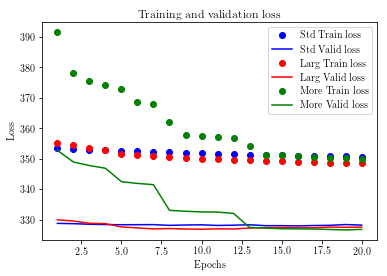

In [109]:
import matplotlib.pyplot as plt

hdict1 = history1.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
hdict3 = history3.history
train_loss_values3 = hdict3['loss']
valid_loss_values3 = hdict3['val_loss']
epochs3 = range(1, len(train_loss_values3) + 1)
hdict5 = history5.history
train_loss_values5 = hdict5['loss']
valid_loss_values5 = hdict5['val_loss']
epochs5 = range(1, len(train_loss_values5) + 1)

plt.plot(epochs1, train_loss_values1, 'bo', label='Std Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Std Valid loss')
plt.plot(epochs3, train_loss_values3, 'ro', label='Larg Train loss')
plt.plot(epochs3, valid_loss_values3, 'r', label='Larg Valid loss')
plt.plot(epochs5, train_loss_values5, 'go', label='More Train loss')
plt.plot(epochs5, valid_loss_values5, 'g', label='More Valid loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(); plt.show()

array([ 1.18169428e-05,  5.12940278e-06,  5.17723674e-06,  2.36581513e-06,
        4.79932132e-05,  2.03128881e-03,  3.00917514e-02,  3.25429067e-02,
        6.41387748e-03,  4.12391014e-02,  1.00992456e+03,  7.46461365e+02,
        2.68334381e+02,  4.53668709e+01,  2.91980400e+01, -9.99487591e+00,
        0.00000000e+00, -7.88744539e-02], dtype=float32)

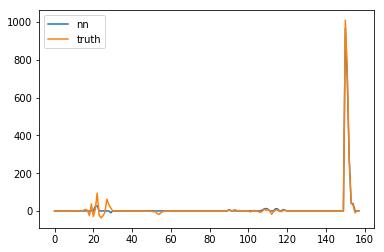

In [175]:
pred1 = model1.predict_on_batch(x)
import matplotlib.pyplot as plt
ind_test = 150;
plt.plot(pred1[ind_test,:], label='nn')
plt.plot(y[ind_test,:], label='truth')
plt.legend();
y[ind_test,140:]

#### Step 4: Comparing to simple dense model with same inputs/outputs

In [110]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range (4):
    densout = Dense(256, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
model2 = Model(inputs=inp, outputs=out)

In [111]:
# Larger layers
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range (4):
    densout = Dense(512, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
model4 = Model(inputs=inp, outputs=out)

In [112]:
# More layers
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range (8):
    densout = Dense(256, activation='relu')(densout)
out = Dense(158, activation='relu')(densout)    
model6 = Model(inputs=inp, outputs=out)

In [117]:
#model6.compile('adam','mse') # Careful, compile resets the weights/biases

In [118]:
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 154)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               39680     
_________________________________________________________________
dense_100 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_101 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_102 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_103 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_104 (Dense)            (None, 256)               65792     
__________

In [ ]:
history2 = model2.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
history4 = model4.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
history6 = model6.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
27456/27456 [==============================] - 132s 5ms/step - loss: 254.8290 - val_loss: 228.2938
Epoch 2/20
27456/27456 [==============================] - 134s 5ms/step - loss: 237.9216 - val_loss: 223.8188
Epoch 3/20
27456/27456 [==============================] - 141s 5ms/step - loss: 224.6774 - val_loss: 207.9285
Epoch 4/20
27456/27456 [==============================] - 127s 5ms/step - loss: 217.5935 - val_loss: 207.2040
Epoch 5/20
27456/27456 [==============================] - 134s 5ms/step - loss: 216.3367 - val_loss: 206.0627
Epoch 6/20
27456/27456 [==============================] - 141s 5ms/step - loss: 215.0186 - val_loss: 204.6537
Epoch 7/20
19634/27456 [====================>.........] - ETA: 33s - loss: 213.6706

In [ ]:
import matplotlib.pyplot as plt

hdict2 = history2.history
train_loss_values2 = hdict2['loss']
valid_loss_values2 = hdict2['val_loss']
epochs2 = range(1, len(train_loss_values2) + 1)
hdict4 = history4.history
train_loss_values4 = hdict4['loss']
valid_loss_values4 = hdict4['val_loss']
epochs4 = range(1, len(train_loss_values4) + 1)
hdict6 = history6.history
train_loss_values6 = hdict6['loss']
valid_loss_values6 = hdict6['val_loss']
epochs6 = range(1, len(train_loss_values6) + 1)

plt.plot(epochs2, train_loss_values2, 'bo', label='Std Train loss')
plt.plot(epochs2, valid_loss_values2, 'b', label='Std Valid loss')
plt.plot(epochs4, train_loss_values4, 'ro', label='Larg Train loss')
plt.plot(epochs4, valid_loss_values4, 'r', label='Larg Valid loss')
plt.plot(epochs6, train_loss_values6, 'go', label='More Train loss')
plt.plot(epochs6, valid_loss_values6, 'g', label='More Valid loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(); plt.show()

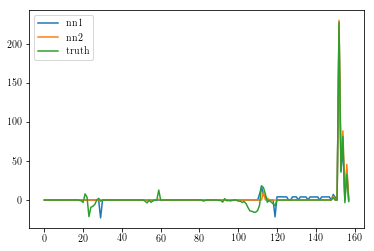

In [45]:
xval, yval = next(validgen)
pred1 = model1.predict_on_batch(xval)
pred2 = model2.predict_on_batch(xval)
pred3 = model3.predict_on_batch(xval)
pred4 = model4.predict_on_batch(xval)
pred5 = model5.predict_on_batch(xval)
import matplotlib.pyplot as plt
ind_test = 15;
plt.plot(pred1[ind_test,:], label='nn1')
plt.plot(pred2[ind_test,:], label='nn2')
plt.plot(pred3[ind_test,:], label='nn3')
plt.plot(pred4[ind_test,:], label='nn4')
plt.plot(pred5[ind_test,:], label='nn5')
plt.plot(y[ind_test,:], label='truth')
plt.legend();

#### Step 5: Check energy and mass conservation for the predictions
If we coded the mass/enthalpy conservation layers properly  
pred1 from the mass/enthalpy-conserving model1 should conserve mass/energy  
pred2 which is a "naive" dense network should be close to conserving mass/energy  
The function below is directly adapted from the tested mass/enthalpy conservation layers in numpy that have been used to develop the tensorflow layers

In [26]:
def massent_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi):
    import numpy as np
    # 0) Constants
    G = 9.80616; # Reference gravity constant [m.s-2]
    L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
    L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
    L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
    P0 = 1e5; # Reference surface pressure [Pa]   

    # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
    # In the input vector, PS is the 151st element after 
    # the first elements = [QBP, ..., VBP with shape 30*5=150]
    PS = np.add( np.multiply( x[:,150], fdiv[150]), fsub[150])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
    np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
    np.multiply(normq[:30], \
              G),\
    L_V)
    # dp_tilde = dp/dp_norm
    dP_TILD = np.divide( dP, dP_NORM)

    # WATER.1) Calculate water vertical integral from level 1 to level 30
    WATVEC = np.multiply( dP_TILD, y[:, :30] + y[:, 30:60] + y[:, 60:90])
    WATINT = np.sum( WATVEC, axis=1)

    # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
    # E-P is already normalized to units W.m-2 in the output vector
    # so all we need to do is input-unnormalize LHF that is taken from the input vector
    LHF = np.add( np.multiply( x[:,153], fdiv[153]), fsub[153])
    # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
    # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
    PREC = np.add( y[:, 154], y[:, 155])

    # WATER.FINAL) Residual = E-P-DWATER/DT
    WATRES = LHF-PREC-WATINT
    
    # ENTHALPY.1) Calculate net energy input from phase change and precipitation
    # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
    PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( y[:,156], y[:,157]),\
                                          np.add( y[:,154], y[:,155])),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
    # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
    RAD = np.add(\
            np.subtract( y[:,150], y[:,151]),\
            np.subtract( y[:,153], y[:,152]))
    # 2.2) Unnormalize sensible heat flux
    SHF = np.add( np.multiply( x[:,152], fdiv[152]), fsub[152])
    # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
    # turbulent kinetic energy energy dissipative heating
    KEDVEC = np.multiply( dP_TILD, y[:, 120:150])
    KEDINT = np.sum( KEDVEC, axis=1)
    
    # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
    # 3.1) Column water vapor is the column integral of specific humidity
    PHQVEC = np.multiply( dP_TILD, y[:, :30])
    PHQINT = np.sum( PHQVEC, axis=1)
    # 3.2) Multiply by L_S/L_V to normalize (explanation above)
    SPDQINT = np.divide( np.multiply( np.subtract(\
                                                 PHQINT, LHF),\
                                    L_S),\
                       L_V)
    
    # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
    SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, y[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.5) Same operation for temperature tendency
    DTINT = np.sum( np.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)
    
    # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
    ENTRES = SPDQINT+SPDQCINT+DTINT-RAD-SHF-PHAS-KEDINT

    import matplotlib.pyplot as plt
    from matplotlib import rc
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(121)
    plt.hist(WATRES)
    plt.xlabel(r"$\mathrm{Water\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplot(122)
    plt.hist(ENTRES)
    plt.xlabel(r"$\mathrm{Enthalpy\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

In [57]:
x, y = next(gen)
pred1 = model1.predict_on_batch(x)
pred2 = model2.predict_on_batch(x)

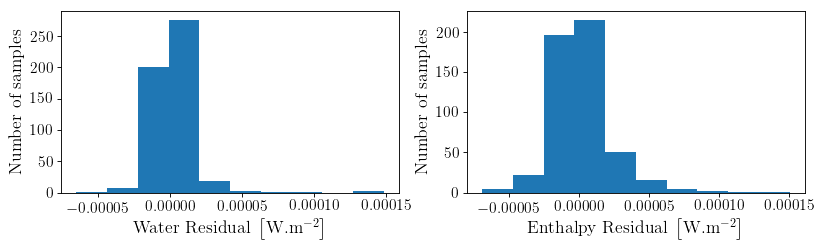

In [42]:
massent_check(x,y)

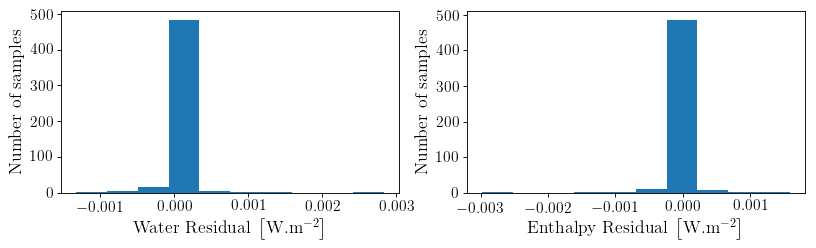

In [43]:
massent_check(x,pred1)

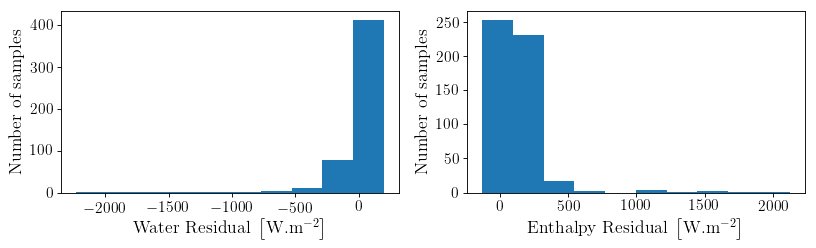

In [44]:
massent_check(x,pred2)

#### Step 6: Check positivity of water species
There are two necessary steps:  
1) Load the water species concentrations "before physics" from the input vector and unnormalize them  
2) Invert the output normalization to get the water concentrations "after physics"

$$
\delta q_{v,i,l}\left(p\right)=\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}\ \Rightarrow\ q_{v,i,l}^{a}\left(p\right)=q_{v,i,l}^{b}\left(p\right)+\frac{g\Delta t}{L_{v}\Delta p_{\mathrm{norm}}}\delta q_{v,i,l}\left(p\right)
$$

In [75]:
def watpos_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,dt=30*60):
    
    import numpy as np

    # 1) Extract water species concentrations from inputs
    QVB = np.add( np.multiply( x[:, :30], fdiv[ :30]), fsub[ :30])
    QLB = np.add( np.multiply( x[:, 30:60], fdiv[ 30:60]), fsub[ 30:60])
    QSB = np.add( np.multiply( x[:, 60:90], fdiv[ 60:90]), fsub[ 60:90])

    # 2) Inverse output normalization and get water concentration after physics
    QVA = QVB + np.divide( dt*y[:, :30] , normq[:30])
    QLA = QLB + np.divide( dt*y[:, 30:60] , normq[:30])
    QSA = QSB + np.divide( dt*y[:, 60:90] , normq[:30])

    import matplotlib.pyplot as plt
    from matplotlib import rc
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(231)
    plt.hist(1e3*QVA)
    plt.xlabel(r"$\mathrm{Water\ vapor\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(232)
    plt.hist(1e3*QLA)
    plt.xlabel(r"$\mathrm{Liquid\ water\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(233)
    plt.hist(1e3*QSA)
    plt.xlabel(r"$\mathrm{Ice\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplot(234)
    plt.hist(1e3*(QVA-QVB))
    plt.xlabel(r"$\mathrm{Water\ vapor\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(235)
    plt.hist(1e3*(QLA-QLB))
    plt.xlabel(r"$\mathrm{Liquid\ water\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(236)
    plt.hist(1e3*(QSA-QSB))
    plt.xlabel(r"$\mathrm{Ice\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

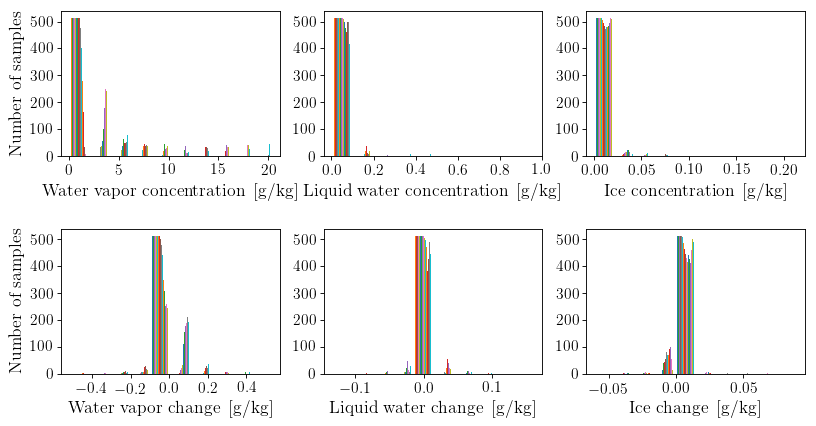

In [76]:
watpos_check(x,y,fsub,fdiv,normq,dt)

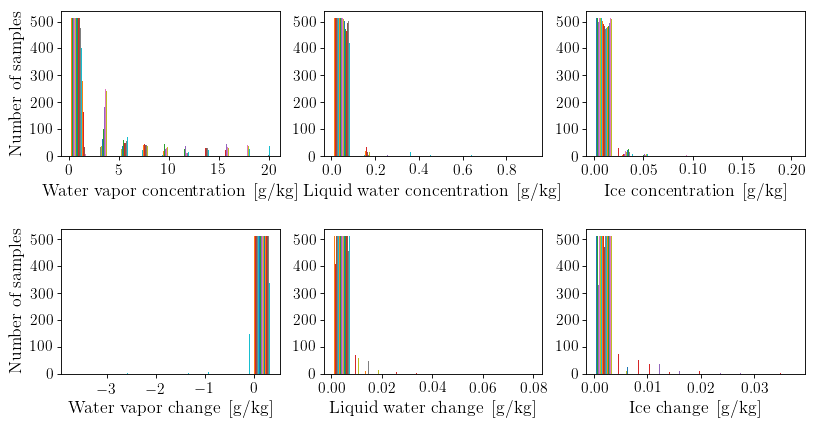

In [77]:
watpos_check(x,pred1,fsub,fdiv,normq,dt)

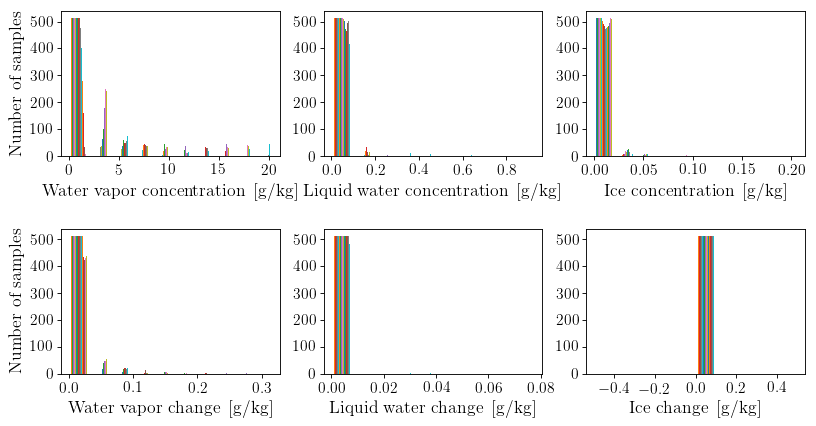

In [78]:
watpos_check(x,pred2,fsub,fdiv,normq,dt)

#### Side step: Debugging
##### Mass conservation layer in Numpy

(512, 156)
dP= [ 277.64523402  512.62555644  839.73696455 1211.38058603 1519.8353678
 1745.60062587 1737.79353499 1423.96241426 1675.21685362 1970.80597281
 2318.55362654 2727.6545763  3197.7786471  3762.02087322 4425.8228367
 5206.75274756 6125.47004496 7206.30310716 8477.84052202 8481.23433368
 7784.10646187 6568.77660212 4882.00930607 2826.34901551 2651.61580947
 2455.40763694 2238.96767435 2003.63136295 1751.24040859 1484.55609408]
dP_TILD= [1.         1.00000001 1.00000003 0.99999998 1.00000003 1.00000002
 1.00000004 1.00000001 1.00000003 1.00000003 0.99999996 1.00000001
 0.99651969 0.99651967 0.99651971 0.99651962 0.99651965 0.99651971
 0.99651979 0.99651972 0.99651965 0.9965197  0.99651979 0.99651977
 0.99651979 0.99651965 0.99651973 0.99651972 0.99651968 0.99716217]
CLDVEC= [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000

Text(0, 0.5, '# of samples')

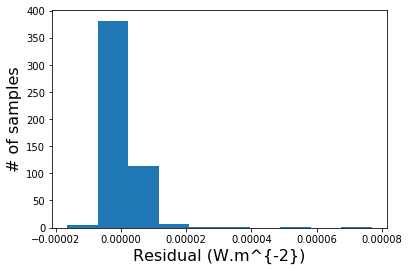

In [189]:
import numpy as np
import copy
x, y = next(gen)
inp = copy.copy(x);
ycop = copy.copy(y);
densout = np.concatenate([ycop[:,:29],ycop[:,30:119],ycop[:,120:]],1)
print(densout.shape)
# 0) Constants
G = 9.80616; # Reference gravity constant [m.s-2]
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
P0 = 1e5; # Reference surface pressure [Pa]
ind_test = 59; # Reference index to test        
    
# 1) Get non-dimensional pressure differences (p_tilde above)
# In the input vector, PS is the 151st element after 
# the first elements = [QBP, ..., VBP with shape 30*5=150]
PS = np.add( np.multiply( inp[:,150], fdiv[150]), fsub[150])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
                        np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
print('dP=',dP[ind_test,:])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                  np.multiply(normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        # Wondering about broadcasting here...
        # tf.div or simply \ would support broadcasting 
dP_TILD = np.divide( dP, dP_NORM)
print('dP_TILD=',dP_TILD[ind_test,:])
        
        # 2) Calculate cloud water vertical integral from level 1 to level 30
        # The indices are tricky here because we are missing del(q_v)@(level 30)
        # so e.g. q_liq@(level 1) is the 30th element of the output of the 
        # previous dense layer
CLDVEC = np.multiply( dP_TILD, \
                                  np.add( densout[:, 29:59], densout[:, 59:89]))
print('CLDVEC=',CLDVEC[ind_test,:])
CLDINT = np.sum( CLDVEC, axis=1)
print('CLDINT=',CLDINT[ind_test])
        
        # 3) Calculate water vapor vertical integral from level 1 to level 29
VAPVEC = np.multiply( dP_TILD[:, :29], \
                                  densout[:, :29])
print('VAPVEC=',VAPVEC[ind_test,:])
VAPINT = np.sum( VAPVEC, axis=1)
print('VAPINT=',VAPINT[ind_test])
        
        # 4) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
LHF = np.add( np.multiply( inp[:,153], fdiv[153]), fsub[153])
SHF = np.add( np.multiply( inp[:,152], fdiv[152]), fsub[152])
print('LHF=',LHF[ind_test])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
# Modification 3 here !!!!!!!!!!!!!
PREC = np.add( densout[:, 152], densout[:, 153])
# !!!!!!!!!!!!!!!! Careful with indices after adding TKE dissipation
print('PREC=',PREC[ind_test])
print('E-P=',LHF[ind_test]-PREC[ind_test])
print('E-P-CLDINT-VAPINT=',LHF[ind_test]-PREC[ind_test]-CLDINT[ind_test]-VAPINT[ind_test])
        # 5) Infer water vapor tendency at level 30 as a residual
        # Use add_n to be able to add multiple variables
# Modification 2 here !!!!!!!!!!!!!!!!!!!!!!!!
DELQV30 = np.divide(np.add(np.add(np.add(LHF,np.negative(PREC)),np.negative(CLDINT)),np.negative(VAPINT)), \
                                 dP_TILD[:, 29])
# !!!!!!!!!!!!!!!!!!!!!!!!!!
print('DELQV30=',DELQV30[ind_test])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,125) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT SURFACE}, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
# Modification 1 here!!!!!!!!!!!!!!!!!!!!!
DELQV30 = np.expand_dims(DELQV30,1)
# !!!!!!!!!!!!!!!!!!!!!!!!!
print(densout[:, :29].shape)
print(densout[:, 29:].shape)
out = np.concatenate([densout[:, :29], DELQV30, densout[:, 29:]], 1)
print(out[ind_test,:119]-y[ind_test,:119]) # Should be 0

import matplotlib.pyplot as plt
plt.hist(out[:,29]-y[:,29])
plt.xlabel("Residual (W.m^{-2})", fontsize=16)
plt.ylabel("# of samples", fontsize=16)

##### FMSE conservation layer in Numpy

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

Text(0, 0.5, '# of samples')

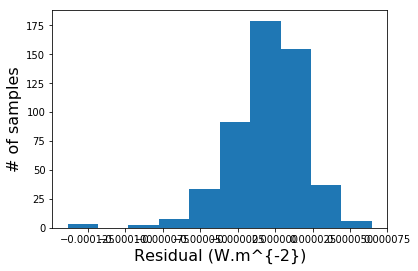

In [151]:
import numpy as np
import copy
x, y = next(gen)
inp = copy.copy(x);
ycop = copy.copy(y);
massout = np.concatenate([ycop[:,:119],ycop[:,120:]],1)

# 0) Constants
dt = 1800; # Timestep [s]
G = 9.80616; # Reference gravity constant [m.s-2]
L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
L_S = L_F+L_V; # Latent heat of sublimation
P0 = 1e5; # Reference surface pressure [Pa]
ind_test = 20;
#print('truth=',y[ind_test,:])
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
PS = np.add( np.multiply( inp[:,150], fdiv[150]), fsub[150])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
                        np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                  np.multiply(normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
dP_TILD = np.divide( dP, dP_NORM)
#print('dP_TILD=',dP_TILD[ind_test,:])
        
# 2) Calculate net energy input from phase change and precipitation
# PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( massout[:,155], massout[:,156]),\
                                          np.add( massout[:,153], massout[:,154])),\
                             L_F),\
                L_V)
#print('Check PHAS=',PHAS[ind_test])

# 3) Calculate net energy input from radiation, sensible heat flux and turbulent KE
# 3.1) RAD = FSNT-FSNS-FLNT+FLNS
RAD = np.add(\
            np.subtract( massout[:,149], massout[:,150]),\
            np.subtract( massout[:,152], massout[:,151]))
#print('Check RAD=',RAD[ind_test])
# 3.2) Unnormalize sensible heat flux
SHF = np.add( np.multiply( inp[:,152], fdiv[152]), fsub[152])
#print('Check SHF=',SHF[ind_test])
# 3.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
# turbulent kinetic energy energy dissipative heating
KEDVEC = np.multiply( dP_TILD, massout[:, 119:149])
KEDINT = np.sum( KEDVEC, axis=1)
#print('Check KEDINT=',KEDINT[ind_test])

# 4) Calculate tendency of normalized column water vapor due to phase change
# 4.1) Unnormalize latent heat flux
LHF = np.add( np.multiply( inp[:,153], fdiv[153]), fsub[153])
#print('Check LHF=',LHF[ind_test])
# 4.2) Column water vapor is the column integral of specific humidity
PHQVEC = np.multiply( dP_TILD, massout[:, :30])
PHQINT = np.sum( PHQVEC, axis=1)
# 4.3) Multiply by L_S/L_V to normalize (explanation above)
SPDQINT = np.divide( np.multiply( np.subtract(\
                                             PHQINT, LHF),\
                                L_S),\
                   L_V)
#print('Check SPDQINT=',SPDQINT[ind_test])

# 5) Same operation for liquid water tendency but multiplied by L_F/L_V
SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, massout[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
#print('Check SPDQCINT=',SPDQCINT[ind_test])

# 6) Same operation for temperature but only integrate from level 1 to level 29
SPDTINT = np.sum( np.multiply( dP_TILD[:, :29], massout[:, 90:119]), axis=1)
#print('Check SPDTINT=',SPDTINT[ind_test])

# 7) Now calculate dT30 as a residual
dT30 = np.divide(np.add(np.add(np.add(np.add(np.add(np.add(\
                                                          PHAS,RAD),\
                                                   SHF),\
                                             KEDINT),\
                                     np.negative( SPDQINT)),\
                              np.negative( SPDQCINT)),\
                       np.negative( SPDTINT)),\
                dP_TILD[:, 29])
dT30 = np.expand_dims(dT30,1)

out = np.concatenate([massout[:, :119], dT30, massout[:, 119:]], 1)
print(out[ind_test,:]-y[ind_test,:]) # Should be 0

        # 2) Calculate latent heat vertical integral from level 1 to level 30
#LATVEC = np.multiply( dP_TILD, \
#                                  np.add( \
#                                    massout[:, :30], \
#                                    np.divide( np.multiply( L_F, \
#                                    np.negative(massout[:, 60:90])), L_V)))
#LATVEC = np.multiply( dP_TILD, \
#                                  np.add( \
#                                    np.divide( np.multiply( L_S, \
#                                    y[:, :30]), L_V), \
#                                    np.divide( np.multiply( L_F, \
#                                    y[:, 30:60]), L_V)))
#LATINT = np.sum( LATVEC, axis=1)
#print('LATVEC=',LATVEC[ind_test,:])
#print('LATINT=',LATINT[ind_test])
################### Functional energy routine for comparison ######################
PHQVEC = np.multiply( dP_TILD, y[:, :30])
PHQINT = np.sum( PHQVEC, axis=1)
LHF = np.add( np.multiply( inp[:,153], fdiv[153]), fsub[153])
#print('LHF=',LHF[ind_test])
SPDQINT = np.subtract( PHQINT, LHF)
#print('SPDQINT',SPDQINT[ind_test],'=PHQINT',PHQINT[ind_test],'-LHF',LHF[ind_test])

PHCVEC = np.multiply( dP_TILD, y[:, 30:60])
SPDQCINT = np.sum( PHCVEC, axis=1)
#print('SPDQCINT',SPDQCINT[ind_test])
        # 3) Calculate sensible heat vertical integral from level 1 to level 29
        # The temperature tendency is contained in 
        # the 91st to 119th element of the output vector
#print('KEDVEC=',KEDVEC[ind_test,:])    
KEDVEC = np.multiply(dP_TILD, y[:, 120:150])
KEDINT = np.sum( KEDVEC, axis=1)
#print('KEDINT=',KEDINT[ind_test])
SHF = np.add( np.multiply( inp[:,152], fdiv[152]), fsub[152])
#print('SHF=',SHF[ind_test])
SW = np.subtract(y[:,150],y[:,151])
LW = np.subtract(y[:,153],y[:,152]);
SENVEC = np.multiply( dP_TILD, y[:, 90:120])
SENINT = np.sum( SENVEC, axis=1)
#SENINT29 = np.sum( np.multiply (dP_TILD[:, :29], y[:, 90:119]), axis=1)
#print('SENINT29=',SENINT29[ind_test])
SPDTINT = np.subtract( SENINT, np.add(np.add(np.add(KEDINT, SHF), SW), LW))
#print('RAD=',LW[ind_test]+SW[ind_test])
#print('SPDTINT',SPDTINT[ind_test],'=DTPHYSINT',SENINT[ind_test],\
#     '-SHF',SHF[ind_test],'-KED',KEDINT[ind_test],'-SW',SW[ind_test],'-LW',LW[ind_test])
        
# Renormalize
SPDQINT_NORM = np.divide( np.multiply( SPDQINT, L_S), L_V)
#print('SPDQINT_NORM=',SPDQINT_NORM[ind_test])
SPDQCINT_NORM = np.divide( np.multiply( SPDQCINT, L_F), L_V)
#print('SPDQCINT_NORM=',SPDQCINT_NORM[ind_test])
#print('SPDQINT_NORM',SPDQINT_NORM[ind_test],' & SPDQCINT_NORM',SPDQCINT_NORM[ind_test])
        # 4) Calculate forcing on the right-hand side (Net radiation + surface ent. fluxes)
        # RHS = SHF+LHF
        # !!!! Modification 1 : Unnormalize LHF and SHF !!!!!!!!!

# Should I multiply LHF by LS/LV?

LIQ = np.divide( np.multiply( y[:,154]+y[:,155], L_F), L_V) # Fallout of liquid precip
ICE = np.divide( np.multiply( y[:,156]+y[:,157], L_F), L_V) # Conversion liq->ice
SINK = ICE-LIQ
#print('SINK=',SINK[ind_test],'=ICE',ICE[ind_test],'-LIQ',LIQ[ind_test])

RESID = SPDQINT_NORM+SPDQCINT_NORM+SPDTINT-SINK
print('RESID',RESID[ind_test])
        # 5) Infer temperature tendency at level 30 as a residual
        # Composites np.add twice because not sure how to use np.add_n
#DELT30 = np.divide( \
#                                np.add(np.add( \
#                                   RHS,np.negative(LATINT)), \
#                                   np.negative(SENINT)), \
#                                dP_TILD[:, 29])
#print('DELT30=',DELT30[ind_test])        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,126) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
#DELT30 = np.expand_dims(DELT30,1)
#out = np.concatenate([massout[:, :119], DELT30, massout[:, 119:]], 1)
#print(out[ind_test,:]-y[ind_test,:]) # Should be 0
import matplotlib.pyplot as plt
plt.hist(out[:,119]-y[:,119])
plt.xlabel("Residual (W.m^{-2})", fontsize=16)
plt.ylabel("# of samples", fontsize=16)


### 3.1) A simple example

In [21]:
inp = Input(shape=(154,))
act = Dense(124, activation='relu')(inp)
for i in range (7):
    act = Dense(124, activation='relu')(act)
out = Dense(125)(act)
model1 = Model(inputs=inp, outputs=out)

In [22]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 154)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 124)               19220     
_________________________________________________________________
dense_2 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_3 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_4 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_5 (Dense)              (None, 124)               15500     
_________________________________________________________________
dense_6 (Dense)              (None, 124)               15500     
__________

In [23]:
model1.compile('adam', loss='mse')

In [24]:
model1.fit_generator(gen, train_gen_obj.n_batches, epochs=10)

Epoch 1/10
9024/9024 [==============================] - 46s 5ms/step - loss: 302.7223
Epoch 2/10
9024/9024 [==============================] - 40s 4ms/step - loss: 214.0051
Epoch 3/10
2746/9024 [========>.....................] - ETA: 27s - loss: 214.7549

KeyboardInterrupt: 

In [17]:
preds = model1.predict_on_batch(x)

In [18]:
preds.shape

(512, 125)

array([ 0.0000000e+00,  0.0000000e+00,  1.1683633e-04, -1.8150534e-04,
        2.8191236e-05, -1.2674624e-04,  3.2557498e-04, -2.3665362e-04,
        1.0368231e-04,  4.4764183e-04,  9.7565079e-04,  6.6266386e-03,
       -2.4458408e-02,  7.7702858e-02, -7.9534091e-02, -3.0769283e-01,
       -2.9614696e-01, -3.2436770e-01, -1.4933038e+01,  1.1325694e+02,
        1.1042747e+02, -1.3367409e+02, -9.7812202e+01, -1.2961019e+01,
       -2.1165226e+01, -3.0767555e+01, -1.5683941e+01,  6.6389933e+00,
       -3.9723598e+01, -5.9443699e+01,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  2.3594544e+00,  6.4320625e+01, -2.1832945e+01,
       -4.4953237e+00,  2.9705560e+00, -4.5950494e+00, -4.7523217e+00,
      

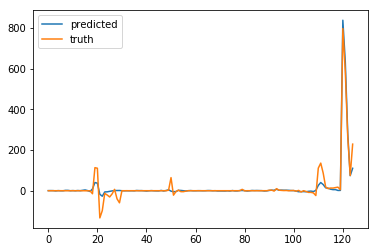

In [19]:
plt.plot(preds[413])
plt.plot(y[413])
plt.legend(['predicted','truth'])
y[413,]
#plt.axis([0,50,-50,20])

### 3.2) Implement energy conservation layer: First attempt focused on positivity
tgb - 1/18/2019 - The hard constraint on q made the optimization problem much much harder 
Two conclusions are: (1) Try to keep it soft constraints for optimization
(2) Maybe predict delta(after-before) physics to avoid getting too different values in the vectors
#### Step 0: Load input's normalization separately

In [17]:
ds = xr.open_dataset(TRAINDIR + '32_col_mp_3d_train_norm.nc')
ds

<xarray.Dataset>
Dimensions:              (feature_lev: 154, target_lev: 125)
Coordinates:
  * feature_lev          (feature_lev) int64 0 1 2 3 4 5 ... 149 150 151 152 153
  * target_lev           (target_lev) int64 0 1 2 3 4 5 ... 120 121 122 123 124
Data variables:
    feature_means        (feature_lev) float32 ...
    feature_stds         (feature_lev) float32 ...
    feature_mins         (feature_lev) float32 ...
    feature_maxs         (feature_lev) float32 ...
    target_means         (target_lev) float32 ...
    target_stds          (target_lev) float32 ...
    target_mins          (target_lev) float32 ...
    target_maxs          (target_lev) float32 ...
    feature_names        (feature_lev) object ...
    target_names         (target_lev) object ...
    feature_stds_by_var  (feature_lev) float32 ...
    target_conv          (target_lev) float32 ...

In [18]:
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print(fsub.shape)
print(fdiv.shape)
print(normq.shape)

(154,)
(154,)
(125,)


In [19]:
ds.close()

#### Step 1: Test the physical constraint layer in Numpy for basic debugging

In [69]:
import numpy as np
a = (156,)
a[0]+1

157

In [24]:
import numpy as np
def safe_softplus(x, limit=30):
  if x>limit:
    return x
  else:
    return np.log(1.0 + np.exp(x))

In [25]:
print(qap.shape)
print(fsub.shape)

NameError: name 'qap' is not defined

In [100]:
x, y = next(gen) # (Input,Output) pair retrieved iteratively from the generator
testinp = x; testdensout = y;  # The output of the densely connected layer,
# which is the input for the physical constraints layer, has shape (125,)=y.shape
qbp = np.add(np.multiply(testinp[:,:90],fdiv[:90,]),fsub[:90,])
index = 5
print(qbp[index,:])
# Bound on dq/dt
np.multiply(normq[:90,],qbp[index,:])/1800

[1.8890089e-06 1.8709759e-06 1.7035223e-06 1.7005252e-06 1.6415983e-06
 1.5045957e-06 1.4606607e-06 1.4591218e-06 1.4598600e-06 1.4735780e-06
 1.5066166e-06 1.5988817e-06 2.0526277e-06 4.9225710e-06 1.0806412e-05
 2.0793159e-05 5.1943964e-05 1.3326522e-04 2.4402043e-04 3.3523864e-04
 6.6088326e-04 1.1144076e-03 1.5189773e-03 1.8160637e-03 2.0421566e-03
 2.2358480e-03 2.4027592e-03 2.5413563e-03 2.7411170e-03 2.9877913e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.7347235e-18 0.0000000e+00 0.0000000e+00 2.2737368e-13 0.0000000e+00
 0.0000000e+00 9.0949470e-13 9.5405994e-09 4.6377809e-06 1.5204386e-05
 1.5759480e-05 4.7640169e-06 1.4436255e-06 1.9511208e-07 5.5640478e-05
 1.2481135e-09 1.0923745e-09 6.6391337e-14 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

array([7.4313283e-02, 1.3589725e-01, 2.0269047e-01, 2.9188102e-01,
       3.5351321e-01, 3.7214047e-01, 3.5965800e-01, 2.9439625e-01,
       3.4651691e-01, 4.1148993e-01, 4.9495089e-01, 6.1794227e-01,
       9.3328631e-01, 2.6331131e+00, 6.8003597e+00, 1.5393726e+01,
       4.5240860e+01, 1.3654811e+02, 2.9414923e+02, 4.0426810e+02,
       7.3145874e+02, 1.0408422e+03, 1.0544020e+03, 7.2981561e+02,
       7.6993835e+02, 7.8058862e+02, 7.6491705e+02, 7.2400189e+02,
       6.8254248e+02, 6.3026514e+02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.2842618e-12, 0.0000000e+00, 0.0000000e+00,
       2.7408277e-07, 0.0000000e+00, 0.0000000e+00, 8.4945623e-07,
       6.6226311e-03, 1.8637701e+00, 5.7323909e+00, 5.5020161e+00,
       1.5166223e+00, 4.1127157e-01, 4.8583217e-02, 1.1737184e

In [109]:
# SOFTPLUS
import copy
qap = copy.copy(testdensout[:,:90])
print(qap)
print(qap[5,:])
for i in range(qap.shape[0]):
    for j in range (qap.shape[1]):
        qap[i,j] = safe_softplus(qap[i,j])
print(qap,qap.shape)          


[[ 0.00000000e+00  0.00000000e+00 -3.52463167e-06 ...  7.14828730e-01
  -1.94745120e-02 -5.09016812e-01]
 [ 0.00000000e+00  0.00000000e+00 -3.91810636e-06 ... -8.12336057e-02
   1.09404393e-01 -2.64686853e-01]
 [ 0.00000000e+00  0.00000000e+00 -3.83413817e-06 ...  2.25569099e-01
  -5.04336655e-02 -1.75489992e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00 -4.57383749e-06 ...  4.15254906e-02
   3.08697671e-01 -1.18188016e-01]
 [ 0.00000000e+00  0.00000000e+00 -5.56462510e-06 ...  8.04110393e-02
  -4.38176608e-03  3.40724625e-02]
 [ 0.00000000e+00  0.00000000e+00 -5.02103740e-06 ... -5.38274534e-02
  -2.09472924e-01 -1.75753996e-01]]
[ 0.0000000e+00  0.0000000e+00 -3.1418069e-06 -3.6398256e-07
  3.0054719e-06 -1.6221151e-05  8.7531935e-06  1.2292489e-05
  1.0967176e-05 -6.3576708e-06  3.7818052e-07 -2.8339788e-04
 -1.0227459e-03 -2.1273026e-03 -3.6572393e-02  2.8603417e-03
 -2.7998945e-01 -4.5961341e-01  9.0005070e-01  6.8134266e-01
 -8.2287771e-01  2.3013981e-01  2.4323208e+00 -8.4881544e-0

#### Step 2: Rigorously implement the physical constraint layer in tensorflow

In [143]:
class PositiveConstraintLayer(Layer):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, inp):
        # inputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # SOFTPLUS PART
        qap = inp[:, :90]
        remain = inp[:, 90:]
        # softplus on x_q
        qap = K.softplus(qap)
        
        # Concat out
        out = K.concatenate([qap, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [144]:
class CloudTendencyLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.normq = normq
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # Identify qap and rest of vector
        qap = densout[:, :90]
        remain = densout[:, 90:]
        
        # OPTION 1
        # 1) Unnormalize qbp
        qbp = inp[:, :90]
        qbp = tf.math.add(tf.math.multiply(qbp,self.fdiv[:90,]),self.fsub[:90,])
        # 2) Calculate temporal difference
        diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Normalize the temporal difference according to output's normalization
        diff = tf.math.multiply(diff,self.normq[:90,])
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [60]:
class PhysicalConstraintLayer(Layer):
    
    def __init__(self, fsub, fdiv, normq, dt=30*60, **kwargs):
        self.fsub = fsub 
        self.fdiv = fdiv
        self.normq = normq
        self.dt = dt
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    def call(self, arrs):
        # arrs (for arrays) is a list with 
        # [inputs and the output of the previous layer]
        # inputs will be [n_sample, 154 = 30*5+4] with
        # [QBP, QCBP, QIBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
        # outputs will be [n_samples, 125 = 30*4+5] with 
        # [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, densout
        inp, densout = arrs
        
        # SOFTPLUS PART
        qap = densout[:, :90]
        remain = densout[:, 90:]
        # softplus on x_q, then multiply by 10^-3 for order of magnitude
        qap = tf.math.multiply(1e-3,K.relu(qap))
        
        # FROM Q TO DQ/DT
        # OPTION 1
        # 1) Unnormalize qbp
        qbp = inp[:, :90]
        qbp = tf.math.add(tf.math.multiply(qbp,self.fdiv[:90,]),self.fsub[:90,])
        # 2) Calculate temporal difference
        diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Normalize the temporal difference according to output's normalization
        diff = tf.math.multiply(diff,self.normq[:90,])
        
        # OPTION 2
        # 1) Normalize qap
        #qap = tf.math.divide(tf.math.subtract(qap,self.fsub[:90,]),self.fdiv[:90,])
        # 2) Calculate temporal difference
        #qbp = inp[:, :90]
        #diff = tf.math.divide(tf.math.subtract(qap,qbp),self.dt)
        # 3) Unnormalize dq/dt
        #diff = tf.math.multiply(diff,self.fdiv[:90,])
        # 4) Normalize the temporal difference according to output's normalization
        #diff = tf.math.multiply(diff,self.normq[:90,])
        
        # Concat out
        out = K.concatenate([diff, remain])
        
        return out
    
    def compute_output_shape(self, input_shape):
        return input_shape[1]

In [61]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range(4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(125, activation='relu')(densout)
out = PhysicalConstraintLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq
)([inp, densout])
m = Model(inputs=inp, outputs=out)

In [146]:
inp = Input(shape=(154,))
densout = Dense(256, activation='relu')(inp)
for i in range(4):
    densout = Dense(256, activation='relu')(densout)
densout = Dense(125, activation='relu')(densout)
densout = PositiveConstraintLayer(
    input_shape=(125,)
)(densout)
out = CloudTendencyLayer(
    input_shape=(125,), fsub=fsub, fdiv=fdiv, normq=normq
)([inp, densout])
m = Model(inputs=inp, outputs=out)

In [64]:
m.compile('adam', 'mse')

In [65]:
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 154)          0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 256)          39680       input_8[0][0]                    
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 256)          65792       dense_43[0][0]                   
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 256)          65792       dense_44[0][0]                   
__________________________________________________________________________________________________
dense_46 (

In [75]:
m.fit_generator(gen, train_gen_obj.n_batches, epochs=18)

Epoch 1/18
9024/9024 [==============================] - 32s 4ms/step - loss: 955.1480
Epoch 2/18
9024/9024 [==============================] - 32s 4ms/step - loss: 901.2071
Epoch 3/18
9024/9024 [==============================] - 35s 4ms/step - loss: 869.4739
Epoch 4/18
9024/9024 [==============================] - 35s 4ms/step - loss: 865.2605
Epoch 5/18
9024/9024 [==============================] - 35s 4ms/step - loss: 879.6664
Epoch 6/18
9024/9024 [==============================] - 36s 4ms/step - loss: 831.5987
Epoch 7/18
9024/9024 [==============================] - 35s 4ms/step - loss: 792.0738
Epoch 8/18
9024/9024 [==============================] - 35s 4ms/step - loss: 836.7333
Epoch 9/18
9024/9024 [==============================] - 36s 4ms/step - loss: 858.6139
Epoch 10/18
9024/9024 [==============================] - 36s 4ms/step - loss: 788.8702
Epoch 11/18
9024/9024 [==============================] - 36s 4ms/step - loss: 801.9747
Epoch 12/18
9024/9024 [=============================

In [76]:
preds = m.predict_on_batch(x)

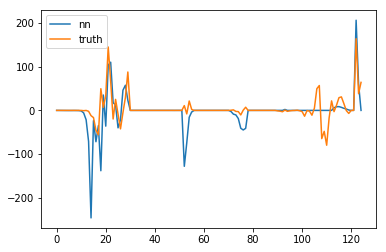

In [77]:
plt.plot(preds[510], label='nn')
plt.plot(y[510], label='truth')
plt.legend();
#plt.axis([0,50,-100,100])

TODO: Validation